# CAPSTONE 3. Predicting Major Cryptocurrencies Prices
## Modeling

In this notebook we will continue to implement different times series forecasting algorithms in order to predict Bitcoin price. In particular, we will build three models:
<ul>
    <i>Exponential Smoothing</i> - a time series forecasting method for univariate data, which can be used as an alternative for ARIMA family of methods<br>
    <i>Prophet</i> - a time-series forecasting model developped by Facebook<br>
    <i>PyCaret</i> - a Python version of the Caret machine learning package in R<br>
</ul>
As always, we will train the models on the training set and evaluate them on the test set. The train and test sets will be the same that we used in the previous notebook.<br>

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly
import seaborn as sns
import warnings
import os
import pycaret
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from fbprophet import Prophet
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from joblib import Parallel
from joblib import delayed
from multiprocessing import cpu_count
from math import sqrt

warnings.filterwarnings('ignore')

#setting figure's default size
sns.set(rc={'figure.figsize':(12,5)})
plt.rcParams['figure.figsize'] = (12,5)

sns.set_style('whitegrid')

pd.options.display.float_format = "{:.3f}".format

First, let's import the data we saved in the previous step. We will use it for our analysis.

In [2]:
df = pd.read_pickle('../PTDD/df.pkl')
train = np.load('../PTDD/train_norm.npy')
test = np.load('../PTDD/test_norm.npy')
btc = pd.read_pickle('../EDA/btc.pkl')
btc_price = btc[['Date', 'Close']].sort_values(by='Date', ascending=True)

In [3]:
print(f'Train set observations: {len(train)}')
print(f'Test set observations: {len(test)}')

Train set observations: 1964
Test set observations: 30


And take a look once again at BTC price time series.

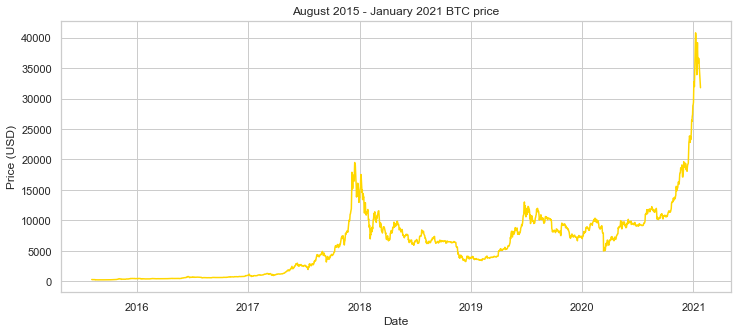

In [4]:
sns.lineplot(data=btc, x='Date', y='Close', color='Gold')
plt.title(f'August 2015 - January 2021 BTC price')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.show();

### Algorithm 1 - Exponential Smoothing

Exponential Smoothing (ES) is a time series forecasting algorithm which can be seen as an analog for Box-Jenkins ARIMA family of methonds. Both of them make a prediction as a weighted sum of previous observations. The main difference is that Exponential Smoothing uses an exponentially decreasing weight for previous observations, using parameter named "alpha". The bigger alpha is, the less important the older observations become for the prediction. If alpha is small, on the other hand, then the model pays more attention to the older obserbations.

There are three types of Exponential Smoothing:<br>
<ol>
    1. Single Exponential Smoothing - does not take into account trend and seasonalirt<br>
    2. Double Exponential Smoothing - takes trend into account<br>
    3. Triple Exponential Smoothing - takes into account both trend and seasonality<br>
</ol>

We know from the previous step that our time series is not stationary. We are not sure if it has clear seasonality, so we will build Double ES model first and than compare it to Triple ES, to see how seasonality will affect the model's performance.<br>
It is also important to understand what kind of trend our time series has - additive or multiplicative (we will need to specify it as a hyperparameter). On the graph we see that even though in the last couple month there is an exponential growth, for 5 years before that the general trend seems to be linear, so we will assume the additive trend as our baseline option.

In [5]:
# train-test split
train_size = int(len(btc_price) * 0.985)
train, test = btc_price[0:train_size], btc_price[train_size:len(btc_price)]
print(f'Total Observations: {(len(btc_price))}')
print(f'Training Observations: {(len(train))}')
print(f'Testing Observations: {(len(test))}')

Total Observations: 1994
Training Observations: 1964
Testing Observations: 30


In [6]:
train.set_index('Date', inplace=True)

In [7]:
# initializing a model, fitting on the train set and predicting for the next 30 observations (equivalent to the test set length)
btc_des_model_add = ExponentialSmoothing(train, trend='add', damped=False)
btc_des_model_add_fit = btc_des_model_add.fit()
print(btc_des_model_add_fit.summary())
btc_des_model_add_pred = btc_des_model_add_fit.forecast(30)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                 1964
Model:             ExponentialSmoothing   SSE                      203161950.346
Optimized:                         True   AIC                          22685.867
Trend:                         Additive   BIC                          22708.198
Seasonal:                          None   AICC                         22685.910
Seasonal Periods:                  None   Date:                 Wed, 21 Jul 2021
Box-Cox:                          False   Time:                         07:30:52
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9950000                alpha                 True
smoothing_trend               0.00

In [8]:
predictions_test_add = [x for x in des_model_add_pred] # List with predicted test values
observations_test_add = [x for x in test['Close']] # List with expected test values

In [9]:
r2 = r2_score(observations_test_add, predictions_test_add)
print(f'Test set r-squared for Double ES (additive) is: {round(r2, 2)}')
mepe = mean_absolute_percentage_error(observations_test_add, predictions_test_add)
print(f'Test set MAPE for Double ES (additive) is: {round(mepe, 2) * 100}%')

Test set r-squared for Double ES (additive) is: -3.28
Test set MAPE for Double ES (additive) is: 28.000000000000004%


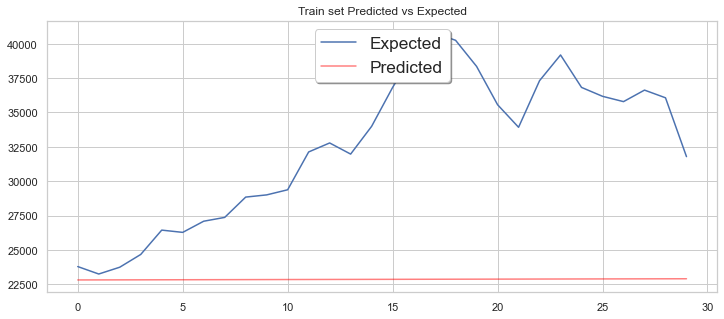

In [10]:
plt.plot(observations_test_add, label='Expected')
plt.plot(predictions_test_add, label='Predicted', color='red', alpha=0.5)
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title("Train set Predicted vs Expected")

plt.show()

As we can see, Exponential Smoothing with additive trend didn't work pretty much at all. We have a negative r-squared which means the model fits the data even worse than just a straight line. The Mean Absolute Percentage Error is also very high (30% against 2% of ARIMA(2,1,1)). Let's try to change the trend parameter to multiplicative.

In [11]:
des_model_mul = ExponentialSmoothing(train, trend='mul', damped=False)
des_model_mul_fit = des_model_mul.fit()
print(des_model_mul_fit.summary())
des_model_mul_pred = des_model_mul_fit.forecast(30)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                 1964
Model:             ExponentialSmoothing   SSE                      202999004.368
Optimized:                         True   AIC                          22684.291
Trend:                   Multiplicative   BIC                          22706.622
Seasonal:                          None   AICC                         22684.334
Seasonal Periods:                  None   Date:                 Wed, 21 Jul 2021
Box-Cox:                          False   Time:                         07:30:52
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9950121                alpha                 True
smoothing_trend           9.9759e-

In [12]:
predictions_test_mul = [x for x in des_model_mul_pred]
observations_test_mul = [x for x in test['Close']]

In [13]:
r2 = r2_score(observations_test_mul, predictions_test_mul)
print(f'Test set r-squared for Double ES (multiplicative) is: {round(r2, 2)}')
mepe = mean_absolute_percentage_error(observations_test_mul, predictions_test_mul)
print(f'Test set MAPE for Double ES (multiplicative) is: {round(mepe, 2) * 100}%')

Test set r-squared for Double ES (multiplicative) is: -2.88
Test set MAPE for Double ES (multiplicative) is: 26.0%


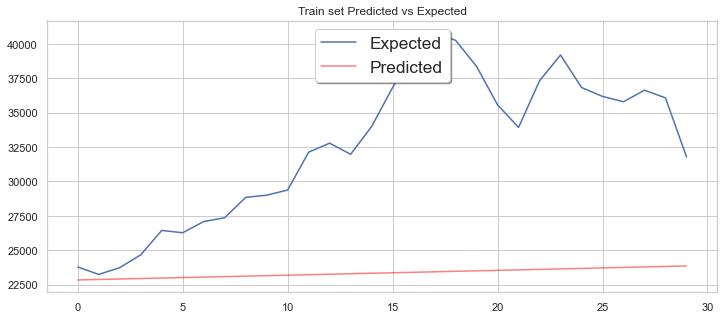

In [14]:
plt.plot(observations_test_mul, label='Expected')
plt.plot(predictions_test_mul, label='Predicted', color='red', alpha=0.5)
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title("Train set Predicted vs Expected")
plt.show()

Still, results are terrible. What might be a reason for it? I assume the reason is the way we splitted our data. If we take a look at the original price chart, we will see a serious structural change at the end of it. Before last month of observations the trend was pretty much linear, while in the last month it's clearly exponential. And that last month is exactly what we used as the test set. We can make a test set bigger (20%, let's say) and then check if the model will be able to catch the trend better.

In [ ]:
# train-test split
train_size = int(len(btc_price) * 0.8)
train, test = btc_price[0:train_size], btc_price[train_size:len(btc_price)]
print(f'Total Observations: {(len(btc_price))}')
print(f'Training Observations: {(len(train))}')
print(f'Testing Observations: {(len(test))}')
train.set_index('Date', inplace=True)

In [20]:
des_model_mul = ExponentialSmoothing(train, trend='mul', damped=False)
des_model_mul_fit = des_model_mul.fit()
print(des_model_mul_fit.summary())
des_model_mul_pred = des_model_mul_fit.forecast(399)

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    Close   No. Observations:                 1595
Model:             ExponentialSmoothing   SSE                      150829455.998
Optimized:                         True   AIC                          18281.965
Trend:                   Multiplicative   BIC                          18303.463
Seasonal:                          None   AICC                         18282.018
Seasonal Periods:                  None   Date:                 Wed, 21 Jul 2021
Box-Cox:                          False   Time:                         07:36:08
Box-Cox Coeff.:                    None                                         
                       coeff                 code              optimized      
------------------------------------------------------------------------------
smoothing_level            0.9950000                alpha                 True
smoothing_trend               0.00

In [21]:
predictions_test_mul = [x for x in des_model_mul_pred]
observations_test_mul = [x for x in test['Close']]

In [22]:
r2 = r2_score(observations_test_mul, predictions_test_mul)
print(f'Test set r-squared for Double ES (multiplicative) is: {round(r2, 2)}')
mepe = mean_absolute_percentage_error(observations_test_mul, predictions_test_mul)
print(f'Test set MAPE for Double ES (multiplicative) is: {round(mepe, 2) * 100}%')

Test set r-squared for Double ES (multiplicative) is: 0.39
Test set MAPE for Double ES (multiplicative) is: 40.0%


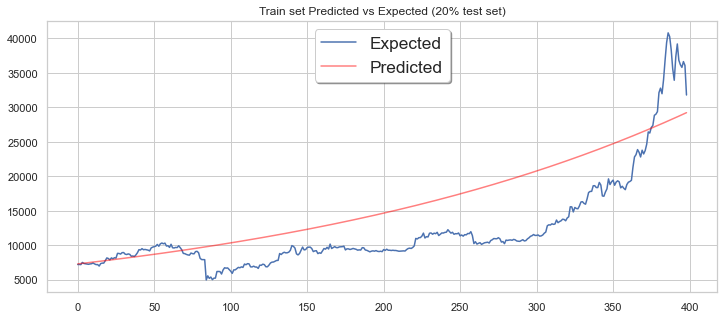

In [24]:
plt.plot(observations_test_mul, label='Expected')
plt.plot(predictions_test_mul, label='Predicted', color='red', alpha=0.5)
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title("Train set Predicted vs Expected (20% test set)")
plt.show()

Indeed, even though the MAPE went higher up to 40%, we can see on the graph that the model was able to catch the general trend. The r-squared is now 0.39 However, it's performance is still significantly worse than the one of our baseline ARIMA(2,1,1) model.

### Algorithm 2 - Facebook Prophet

Next, we will start with Facebook Prophet model.<br>
Prophet is a time-series forecasting algorithm developped by Facebook and is a part of Kats - a framework for time-series analysis, which includes several models. It is important to note that, according to its developers, the main idea behind Prophet is to make *generic* time series analysis easier - generic meaning time series that are most common in business, which have any of the following characteristics:<br>
<ul>
    - hourly, daily, or weekly observations with at least a few months (preferably a year) of history<br>
    - strong multiple “human-scale” seasonalities: day of week and time of year<br>
    - important holidays that occur at irregular intervals that are known in advance<br>
    - a reasonable number of missing observations or large outliers<br>
    - historical trend changes, for instance due to product launches or logging changes<br>
    - trends that are non-linear growth curves, where a trend hits a natural limit or saturates<br>
</ul>
    
Prophet "<i>implements a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects</i> [Package "prophet", 2019].<br>

The Prophet's fit() function takes a DataFrame of time series data. The DataFrame must have a specific format. The first column must have the name ‘ds‘ and contain the datetime objects. The second column must have the name ‘y‘ and contain the observations.

In [27]:
# subsetting the "date" and "close" columns from the original dataframe
btc_prophet_df = btc[['Date', 'Close']]
# renaming the columns according to Prophet's standard
btc_prophet_df.columns = ['ds', 'y']
# making sure 'ds' column observations are datetime objects
btc_prophet_df['ds'] = pd.to_datetime(btc_prophet_df['ds'])

In [34]:
btc_prophet_df = btc_prophet_df.sort_values(by='ds', ascending=True)

In [36]:
# train-test split
test_size = int(len(btc_prophet_df) * 0.8)
train_pr, test_pr = btc_prophet_df[0:train_size], btc_prophet_df[train_size:len(btc_prophet_df)]
print(f'Total Observations: {(len(btc_prophet_df))}')
print(f'Training Observations: {(len(train_pr))}')
print(f'Testing Observations: {(len(test_pr))}')

Total Observations: 1994
Training Observations: 1595
Testing Observations: 399


In [41]:
btc_prophet_mod = Prophet(daily_seasonality=False);
btc_prophet_mod.fit(train_pr);
btc_prophet_pred = btc_prophet_mod.predict(test_pr)
print(btc_prophet_pred[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].head())

          ds      yhat  yhat_lower  yhat_upper
0 2019-12-19 10382.120    9053.111   11692.980
1 2019-12-20 10441.352    9134.078   11851.982
2 2019-12-21 10497.930    9090.707   11855.040
3 2019-12-22 10516.127    9178.568   11921.244
4 2019-12-23 10557.695    9187.927   11936.149


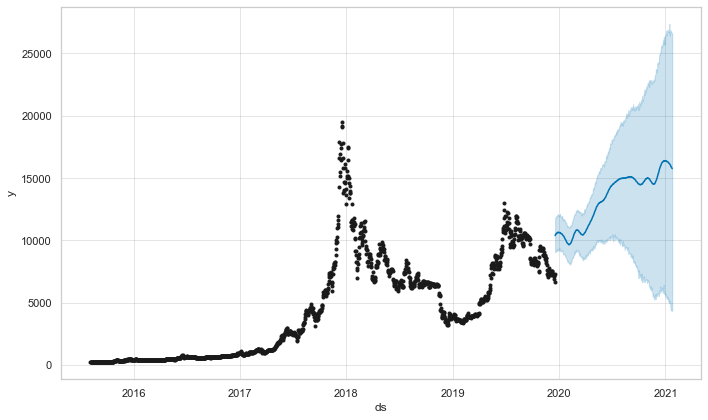

In [42]:
btc_prophet_mod.plot(btc_prophet_pred);

In [43]:
r2 = r2_score(test_pr['y'], btc_prophet_pred['yhat'])
print(f'Test set r-squared for Prophet is: {round(r2, 2)}')
mepe = mean_absolute_percentage_error(test_pr['y'], btc_prophet_pred['yhat'])
print(f'Test set MAPE for Prophet is: {round(mepe,2) * 100}%')

Test set r-squared for Prophet is: 0.27
Test set MAPE for Prophet is: 36.0%


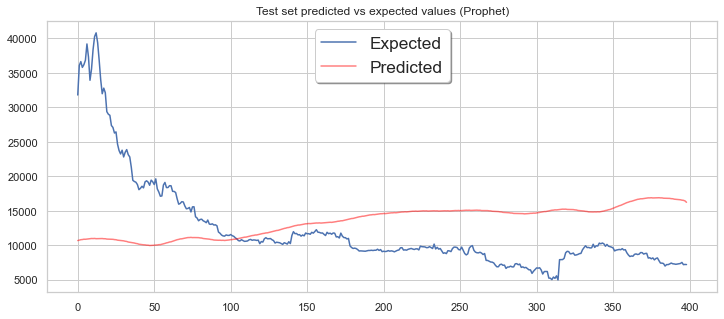

In [40]:
plt.plot(test_pr['y'], label='Expected')
plt.plot(btc_prophet_pred['yhat'], label='Predicted', color='red', alpha=0.5)
legend = plt.legend(loc='upper center', shadow=True, fontsize='x-large')
plt.title('Test set predicted vs expected values (Prophet)')
plt.show()

Again, the results are bad. This is, however, a little bit more understandable. As I mentioned above, Prophet is not really created to handle time-series like BTC price - which is quite volatile, doesn't have clear seasonality and overall hard to predict.

### Algorithm 3 - Pycaret

PyCaret is a Python open source machine learning library. It is a python version of popular R package "Caret". The main ides of this package is to allow easy modeling, evaluation and tuning of classification and regression algorithms. Time series analysis, being a case of regression, can also be performed with pycaret.

PyCaret in its core consists of three main functions:<br>
<ol>
    1. setup() - this function takes as arguments dataframe and target and allows for simple data preparation<br>
    2. compare_models() - this function evaluates models using 10-fold cross-validation and return the single best model<br>
    3. tune_model() - this function takes a given model as an argument and performs random search of hyperparemeters, optimizing model "Accuracy" by default<br>
</ol>
First, let's set up the dataset using setup() function.